In [1]:
import msprime, time, tsdate, tsinfer
import tskit
import numpy as np
from IPython.display import SVG
import plotly.io
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tqdm
import COPYtest_extend_paths as ee
import msprime, tskit
import numpy as np
import typing
import dataclasses

In [2]:
ts = msprime.sim_ancestry(50)
b = ee.extend_paths(ts, 100000)
print(ts.num_edges, b.num_edges)

198 198


In [4]:
samples = 50
ts = msprime.sim_ancestry(samples, population_size = 1000, sequence_length = 1e6, record_full_arg = True, random_seed = 73,
                             recombination_rate = 1e-8)
sts = ts.simplify()
ext = ee.extend_paths(sts)
print(sts.num_edges, ext.num_edges)

857 549


In [5]:
ext.tables.edges.num_rows, sts.num_edges, sts.extend_edges().num_edges

(549, 857, 585)

In [6]:
ext.extend_edges().num_edges

549

In [7]:
ext.simplify().tables.assert_equals(sts.tables, ignore_provenance=True)

In [9]:
tskit.set_print_options(max_lines = 10)
ts = msprime.sim_ancestry(samples, population_size = 1000, sequence_length = 5e6, record_full_arg = True, random_seed = 7,
                             recombination_rate = 1e-8)
sts = ts.simplify()
ext = sts.extend_edges()

In [10]:
ext.tables.edges.num_rows, sts.tables.edges.num_rows

(2208, 3529)

In [68]:
sts.extend_edges().num_edges

2208

In [73]:
t = ext.tables.copy()
t.edges.squash()
t.edges.num_rows

3045

In [12]:
lengths = [1e5, 5e5, 1e6, 5e6, 1e7, 5e7]
samples = 100
res = {}
trees = np.zeros((len(lengths),10))
sim = np.zeros((len(lengths),10))
ext = np.zeros((len(lengths),10))
times = np.zeros((len(lengths),10))
for k in tqdm.tqdm(range(10)):
    for i, L in enumerate(lengths):
        ts = msprime.sim_ancestry(samples, population_size=1000, sequence_length=L,
                                 record_full_arg = True, recombination_rate = 1e-8)
        sts = ts.simplify()
        ext_sts = ee.extend_paths(sts, 10000)
        print(i,'extended!')
        trees[i][k] = ts.num_trees
        sim[i][k] = sts.num_edges
        ext[i][k] = ext_sts.num_edges
        
        sts_start = time.time()
        sts.Tajimas_D()
        sts_end = time.time()
        ext_start = time.time()
        ext_sts.Tajimas_D()
        ext_end = time.time()
        print(i,'timed!')
        times[i][k] = (ext_end-ext_start)/(sts_end-sts_start)
        

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

0 extended!
0 timed!
1 extended!
1 timed!
2 extended!
2 timed!
3 extended!
3 timed!
4 extended!
4 timed!


  0%|                                                                                            | 0/10 [38:24<?, ?it/s]


KeyboardInterrupt: 

In [6]:
trees, sim, ext

(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [398., 398., 398., 398., 398., 398., 398., 398., 398., 398.]]),
 array([[398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [398., 398., 398., 398., 398., 398., 398., 398., 398., 398.],
        [398., 398., 398., 398., 398., 398., 398., 398., 398., 398.]]))

## FIGURE:
Two-part figure, showing reduction in number of edges (left) and increase in speed of stats comptuation (right)
        as a function of number of trees (modulated by sequence length),
        on reasonably big simulated sequences.
        For "speed": plot ratio of runtime before/after extending.

In [14]:
tr = np.average(trees[:4], axis=1)
s = np.average(sim[:4],axis=1)
e = np.average(ext[:4],axis=1)
ti = np.average(times[:4],axis=1)

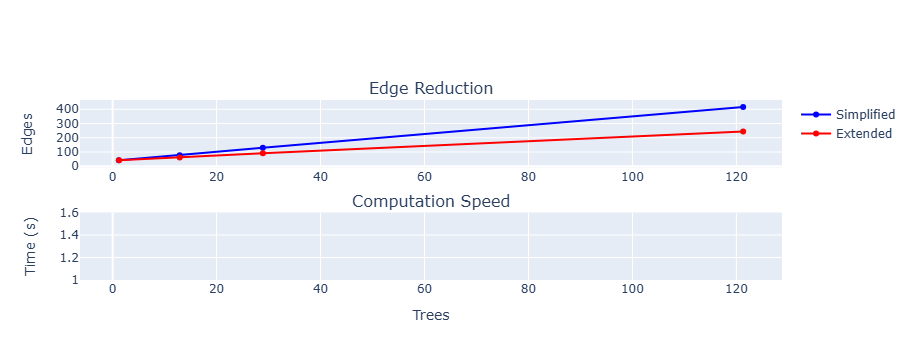

In [17]:
f = make_subplots(rows=2, cols=1, subplot_titles=('Edge Reduction', 'Computation Speed'))
f.add_trace(
    go.Scatter(x=tr, y=s, name='Simplified', mode='lines+markers', marker=dict(color='blue')), 
    row=1,col=1)
f.add_trace(
    go.Scatter(x=tr, y=e, name='Extended', mode = 'lines+markers', marker=dict(color='red'))
    ,row=1, col=1)
f.add_trace(
    go.Scatter(x=tr, y=1/ti, name= 'Extended/Simplified', mode='lines+markers', marker=dict(color='green'), showlegend=False)
    , row=2, col=1)
f.update_xaxes(title_text = 'Trees', row=2, col=1)
f.update_yaxes(title_text = 'Edges', row=1, col=1)
f.update_yaxes(title_text = 'Time (s)', range = (1,1.6), row=2, col=1)
f.update_layout()
f.show()
# plotly.io.write_image(f, 'paper/Edge_reduc_comp_speed.pdf', format='pdf')

In [18]:
ti

array([0.02482532, 0.06667795, 0.05392552, 0.02584405])